<a href="https://colab.research.google.com/github/chstrkn/IwasGutokGym/blob/main/IwasGutokGym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Gym Crowdedness Using Machine Learning Models

## Data Exploration

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fetch the dataset from the GitHub repository using the raw URL
!wget https://raw.githubusercontent.com/chstrkn/IwasGutokGym/refs/heads/main/data.csv

--2024-12-09 14:10:59--  https://raw.githubusercontent.com/chstrkn/IwasGutokGym/refs/heads/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3447605 (3.3M) [text/plain]
Saving to: ‘data.csv.2’

data.csv.2          100%[===================>]   3.29M  --.-KB/s    in 0.05s   

2024-12-09 14:11:00 (64.5 MB/s) - ‘data.csv.2’ saved [3447605/3447605]



In [ ]:
# Load the dataset
df = pd.read_csv('data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [ ]:
# Drop the 'date' column
df = df.drop(columns=['date'])

df

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,61211,4,0,0,71.76,0,0,8,17
1,45,62414,4,0,0,71.76,0,0,8,17
2,40,63015,4,0,0,71.76,0,0,8,17
3,44,63616,4,0,0,71.76,0,0,8,17
4,45,64217,4,0,0,71.76,0,0,8,17
...,...,...,...,...,...,...,...,...,...,...
62179,23,67348,5,1,0,61.07,0,1,3,18
62180,21,67955,5,1,0,61.07,0,1,3,18
62181,25,68560,5,1,0,56.71,0,1,3,19
62182,18,69167,5,1,0,56.71,0,1,3,19


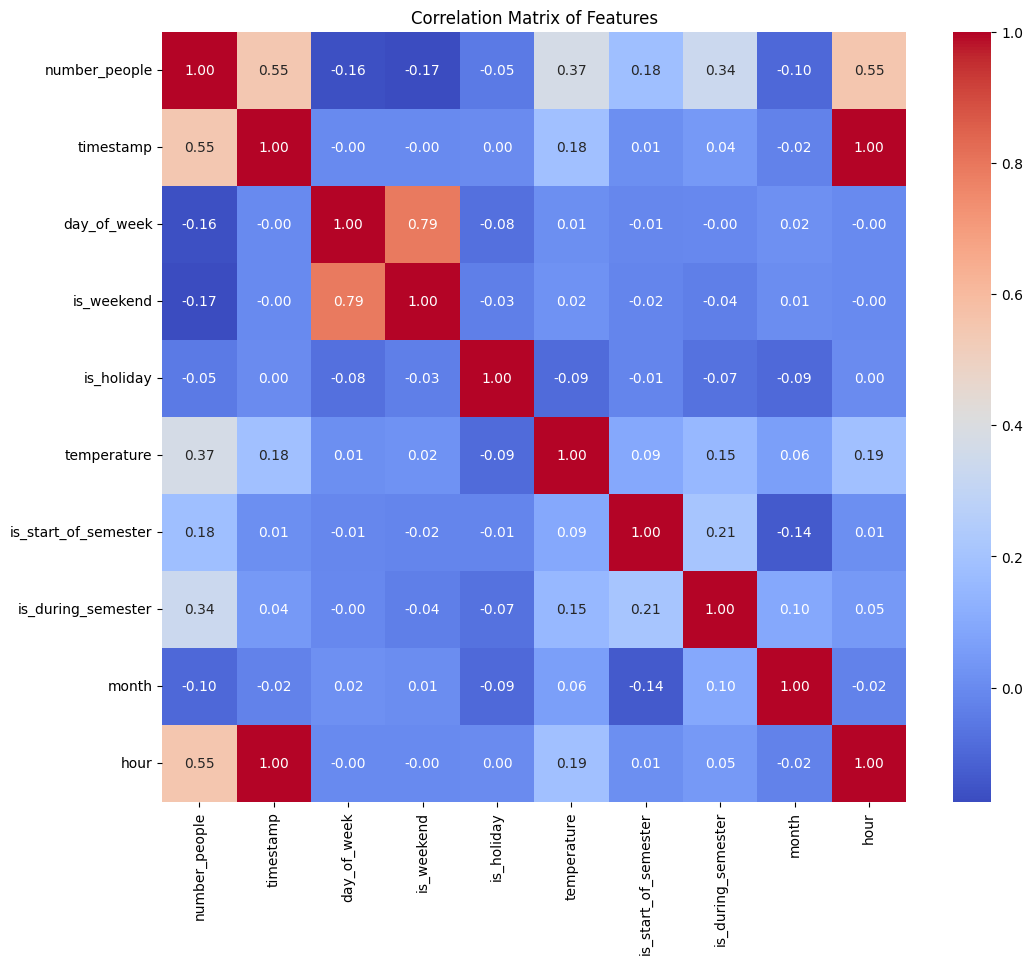

In [ ]:
# Generate the correlation matrix for the features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

Based on the correlation matrix of features, the variables `timestamp` (0.55) and `hour` (0.55) show a moderately strong positive linear association with number_people. Additionally, `temperature` (0.37) and `is_during_semester` (0.34) show a moderately weak positive linear association with `number_people`. The remaining features show a weak negative linear association with number_people, except for `is_start_of_semester`, which has a weak positive linear association.

Since `timestamp` and `hour` essentially provide the same information (with a perfect positive linear association of 1.00), where `timestamp` is more precise as it provides the exact time down to seconds, we will retain `hour` for simplicity, as scaling `timestamp` is unnecessary.

Similarly, as `day_of_week` and `is_weekend` have a strong positive linear association, we will remove `is_weekend` and retain `day_of_week` since they provide the same information.

In [ ]:
# Drop the 'timestamp' and 'is_weekend' columns
df = df.drop(columns=['timestamp', 'is_weekend'])

df

,number_people,day_of_week,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,4,0,71.76,0,0,8,17
1,45,4,0,71.76,0,0,8,17
2,40,4,0,71.76,0,0,8,17
3,44,4,0,71.76,0,0,8,17
4,45,4,0,71.76,0,0,8,17
...,...,...,...,...,...,...,...,...
62179,23,5,0,61.07,0,1,3,18
62180,21,5,0,61.07,0,1,3,18
62181,25,5,0,56.71,0,1,3,19
62182,18,5,0,56.71,0,1,3,19


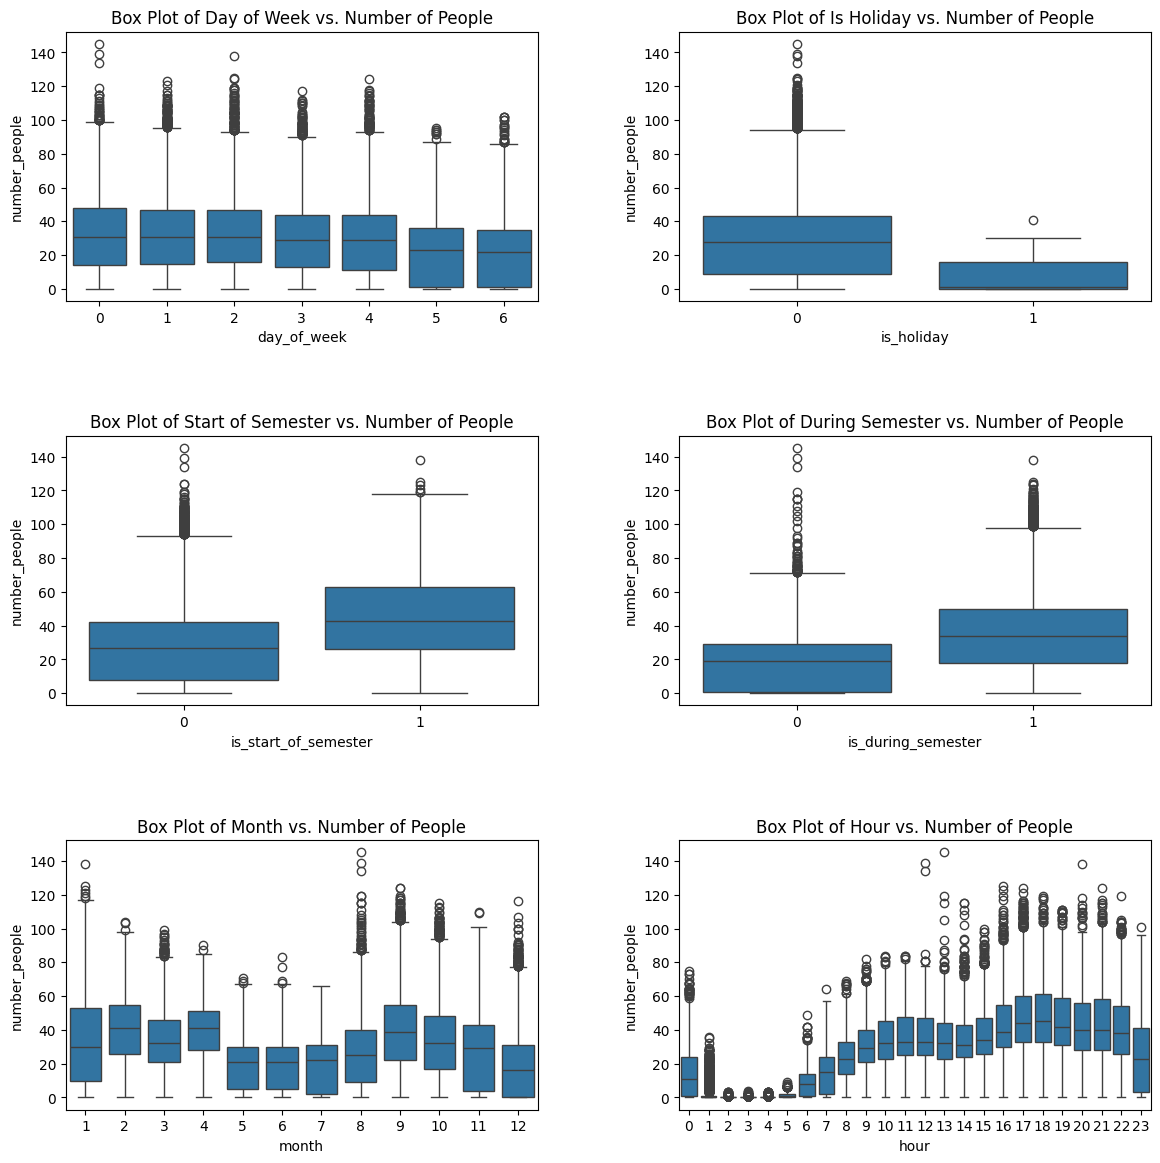

In [ ]:
# Box plots for categorical features against the number of people
plt.figure(figsize=(14, 14))

# Box plot for day_of_week
ax_day_of_week = plt.subplot(3, 2, 1)
sns.boxplot(data=df, x="day_of_week", y="number_people", ax=ax_day_of_week)
ax_day_of_week.set_title("Box Plot of Day of Week vs. Number of People")

# Box plot for is_holiday
ax_is_holiday = plt.subplot(3, 2, 2)
sns.boxplot(data=df, x="is_holiday", y="number_people", ax=ax_is_holiday)
ax_is_holiday.set_title("Box Plot of Is Holiday vs. Number of People")

# Box plot for is_start_of_semester
ax_is_start_of_semester = plt.subplot(3, 2, 3)
sns.boxplot(data=df, x="is_start_of_semester", y="number_people", ax=ax_is_start_of_semester)
ax_is_start_of_semester.set_title("Box Plot of Start of Semester vs. Number of People")

# Box plot for is_during_semester
ax_is_during_semester = plt.subplot(3, 2, 4)
sns.boxplot(data=df, x="is_during_semester", y="number_people", ax=ax_is_during_semester)
ax_is_during_semester.set_title("Box Plot of During Semester vs. Number of People")

# Box plot for month
ax_month = plt.subplot(3, 2, 5)
sns.boxplot(data=df, x="month", y="number_people", ax=ax_month)
ax_month.set_title("Box Plot of Month vs. Number of People")

# Box plot for hour
ax_hour = plt.subplot(3, 2, 6)
sns.boxplot(data=df, x="hour", y="number_people", ax=ax_hour)
ax_hour.set_title("Box Plot of Hour vs. Number of People")

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

Based on the box plot of `day_of_week` against `number_people`, we can see that the median number of people during weekdays (30) is higher compared to weekends (20). Furthermore, the crowd can reach up to around 120 during weekdays, but only around 100 during weekends. Monday has the highest number of people, reaching up to 140.

Based on the box plot of `is_holiday` against `number_people`, we can see that the number of gym-goers drops during holidays, with the median being zero, while on normal days, it is around 20.

Based on the box plot of `is_start_of_semester` against `number_people`, we can see that the gym crowd is higher (around 40) at the start of the semester and drops to 30 as the semester goes on. However, there are some rare cases where more people go to the gym when it is not the start of the semester.

Based on the box plot of `is_during_semester` against `number_people`, we can see that more people go to the gym during the semester, with a median around 30, while the median is lower (around 20) during semester breaks. However, there are some rare cases where more people go to the gym during semester breaks.

Based on the box plot of `month` against `number_people`, we can see that fewer people go to the gym from May to July, and the number starts to increase around August, which is usually the start of the first semester. The number drops again in December and goes back up from January to April, the start of the second semester. The crowd in January can exceed 100, possibly due to New Year's resolutions to go to the gym.

Based on the graph of `hour` against `number_people`, we can see that the gym starts to get crowded (median of 40) around 4 PM, and the crowd starts to decrease after 10 PM. The latest time people stay at the gym is 1 AM, with almost no one there from 2 AM to 5 AM. The median is also below 20 from 6 AM until 8 AM, after which it starts to increase to 30.

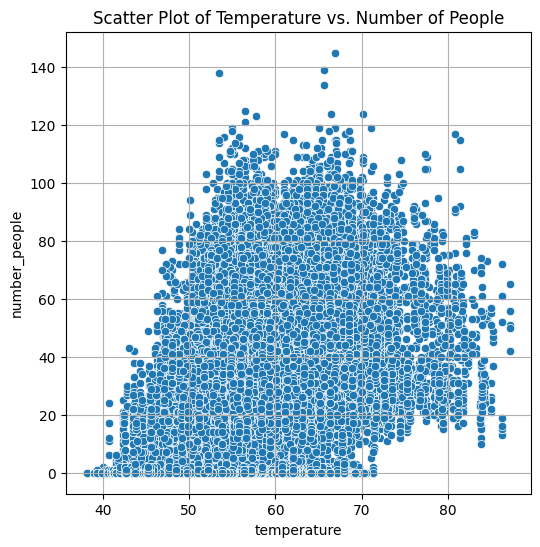

In [ ]:
# Scatter plot of temperature against the number of people
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="temperature", y="number_people")
plt.grid(True)
plt.title("Scatter Plot of Temperature vs. Number of People")
plt.show()

Based on the scatter plot of `temperature` vs. `number_people`, we can see that most people do not go to the gym during cold weather, where the number of people does not exceed 20 at 40°F. Conversely, the gym is never empty and is always crowded with at least around 20 people when the temperature exceeds 70°F.

## Model Selection

In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

### Train and Evaluate Linear Regression, KNN, Decision Tree, Random Forest, SVR, XGBoost on All Features

In [ ]:
# Define features and target variable
X = df.drop(columns=['number_people'])
y = df['number_people']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate models
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
results_df

,MSE,RMSE,R2
Linear Regression,252.485858,15.889804,0.511489
KNN,57.715806,7.597092,0.888331
Decision Tree,39.923459,6.318501,0.922756
Random Forest,38.941493,6.240312,0.924656
SVR,192.618697,13.878714,0.627320
XGBoost,82.712277,9.094629,0.839968


Based on the evaluation of the six different machine learning models, we can see that Random Forest has the highest R2 score (0.92), along with the lowest MSE (38.82) and RMSE (6.23), which suggests that Random Forest is the top-performing model. It is closely followed by Decision Tree with an R2 score of (0.92), low MSE (39.97), and RMSE (6.32). The KNN (K-Nearest Neighbors) model ranks third, showing a high R2 score of (0.89) and a relatively low MSE (57.72) and RMSE (7.60).

The results of the evaluation suggest that Random Forest is the most suitable and reliable model for predicting gym crowdedness. Decision Tree and KNN also perform well and can serve as alternative models for this project.


### Train and Evaluate Linear Regression, KNN, Decision Tree, Random Forest, SVR, and XGBoost on the Three Significant Features Based on the Correlation Matrix

In [ ]:
# Define features and target variable
X = df[['hour', 'temperature', 'is_during_semester']]
y = df['number_people']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate models
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
results_df

,MSE,RMSE,R2
Linear Regression,277.382846,16.654815,0.463318
KNN,98.103469,9.904720,0.810189
Decision Tree,70.323568,8.385915,0.863938
Random Forest,70.544872,8.399099,0.863509
SVR,223.860935,14.961983,0.566873
XGBoost,153.502430,12.389610,0.703003


Comparing the evaluation metrics of the models using only the three significant features versus using all the features, the R2 scores of all models decrease. This indicates that the models become less accurate when even the less significant features are removed. It is recommended to use the models where all features are considered.

Furthermore, the top three performing models using all features are still the same top three when considering only the three significant features.

### Train and Evaluate the Top Three Models by Removing One Feature at a Time

In [ ]:
# Initialize models
models = {
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
}

# Define the feature combinations
feature_combinations = [
    ['is_holiday', 'temperature', 'is_start_of_semester', 'is_during_semester', 'month', 'hour'],  # Remove 'day_of_week'
    ['day_of_week', 'temperature', 'is_start_of_semester', 'is_during_semester', 'month', 'hour'],  # Remove 'is_holiday'
    ['day_of_week', 'is_holiday', 'is_start_of_semester', 'is_during_semester', 'month', 'hour'],  # Remove 'temperature'
    ['day_of_week', 'is_holiday', 'temperature', 'is_during_semester', 'month', 'hour'],  # Remove 'is_start_of_semester'
    ['day_of_week', 'is_holiday', 'temperature', 'is_start_of_semester', 'month', 'hour'],  # Remove 'is_during_semester'
    ['day_of_week', 'is_holiday', 'temperature', 'is_start_of_semester', 'is_during_semester', 'hour'],  # Remove 'month'
    ['day_of_week', 'is_holiday', 'temperature', 'is_start_of_semester', 'is_during_semester', 'month'],  # Remove 'hour'
]

# Loop through feature combinations
results = {}
for feature_set in feature_combinations:
    # Define features and target variable
    X = df[feature_set]
    y = df['number_people']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling: Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train and evaluate models for the current feature set
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store the results for each feature combination
        results_key = f'{model_name} - {", ".join(feature_set)}'
        results[results_key] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Sort the results by R2 score and display the results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='R2', ascending=False)
results_df.head()

,MSE,RMSE,R2
"Random Forest - day_of_week, temperature, is_start_of_semester, is_during_semester, month, hour",38.678989,6.219243,0.925164
"Random Forest - day_of_week, is_holiday, temperature, is_during_semester, month, hour",38.763667,6.226047,0.925000
"Random Forest - day_of_week, is_holiday, temperature, is_start_of_semester, month, hour",39.088304,6.252064,0.924372
"Decision Tree - day_of_week, temperature, is_start_of_semester, is_during_semester, month, hour",39.942699,6.320024,0.922719
"Decision Tree - day_of_week, is_holiday, temperature, is_during_semester, month, hour",39.958163,6.321247,0.922689


Based on the results of training and evaluating the top three models by removing one feature at a time, Random Forest performs the best. Interestingly, removing `is_holiday` makes the model perform better to using all features. Overall, it is safe to say that Random Forest is the most appropriate model to use in predicting gym crowdedness.

## Model Evaluation

Since Random Forest is the most appropriate model to use in predicting gym crowding, let us examine the importance of each feature.

In [ ]:
# Define features and target variable
X = df.drop(columns=['number_people'])
y = df['number_people']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Store and display results
results = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
results_df = pd.DataFrame([results], index=['Random Forest'])
results_df

,MSE,RMSE,R2
Random Forest,38.935277,6.239814,0.924668


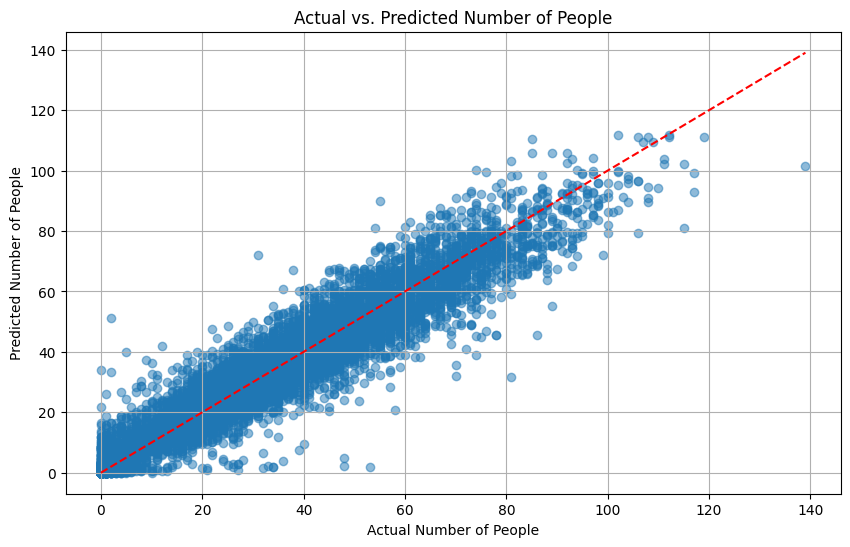

In [ ]:
# Scatter plot of actual vs. predicted number of people
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Number of People")
plt.ylabel("Predicted Number of People")
plt.title("Actual vs. Predicted Number of People")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()

Based on the scatter plot of actual vs. predicted number of people, we can see that most of the points align along the diagonal line, which indicates that most predictions closely match the actual values. However, some outliers in the actual values cannot be predicted.

In [ ]:
# Get feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

importance_df

,Feature,Importance
0,day_of_week,0.091176
1,is_holiday,0.000089
2,temperature,0.178778
3,is_start_of_semester,0.013709
4,is_during_semester,0.110485
5,month,0.083626
6,hour,0.522136


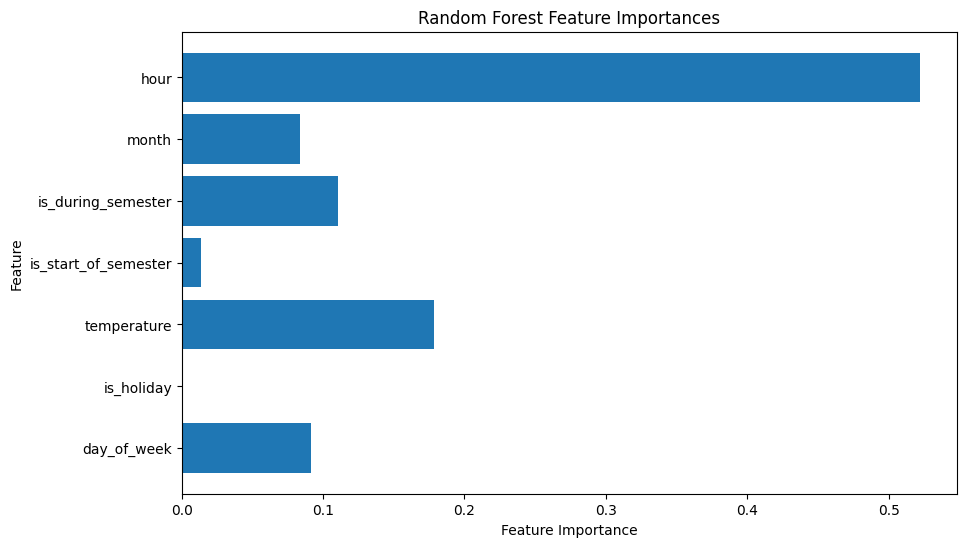

In [ ]:
# Horizontal bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

By analyzing the importance of each feature, it is possible to determine which factors most significantly affect the number of people in the gym.

- `hour` has the highest importance score (0.52), indicating that the time of day is the most influential factor in predicting gym crowdedness. This suggests that gym usage patterns vary significantly throughout the day.

- The second most important feature is `temperature` (0.18), suggesting that weather conditions also play a role in gym attendance. Based on the box plot in the data exploration, people tend to avoid going to the gym when the temperature is around 40°F, whereas the gym is never empty during warmer temperatures like 80°F.

- `is_during_semester` has a moderate importance score (0.11), implying that gym usage is affected by whether or not it is during the academic semester. Based on data exploration, more people tend to go to the gym during the semester and fewer during breaks. This could be because some students leave campus to return home during semester breaks.

- `day_of_week` has a moderate importance score (0.09), indicating that gym attendance varies across different days of the week. Weekdays, especially Mondays, see more gym attendance compared to weekends.

- `month` has an importance score of 0.08, suggesting that the month of the year has some influence on gym crowdedness. From the box plot in the data exploration, it seems that gym crowdedness based on the month may be correlated with whether it is during the semester or a break. For instance, during semester breaks, typically from June to August, the gym tends to have fewer people.

- `is_start_of_semester` has a relatively low importance score (0.01), indicating that the start of the semester has minimal impact on gym attendance.

- `is_holiday` has the lowest importance score (8.6e-05), suggesting that holidays have a negligible effect on gym crowdedness. Furthermore, removing this feature slightly improves the R2 score of the Random Forest model.

## Conclusion

Based on the results, the most optimal time to visit the gym is during the early hours of the day and in colder weather. Additionally, weekends, particularly during semester breaks, tend to have fewer people. Considering these factors can help students plan their gym visits to minimize gym crowdedness.